In [1]:
import numpy as np
import xarray as xr
import xesmf as xe
from eofs.xarray import Eof
from eofs.examples import example_data_path
import xgcm
from sklearn import preprocessing
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
from scipy import stats

import matplotlib.pyplot as plt
import cartopy.feature as cft
import cartopy.crs as ccrs
import cmocean as cm

import cosima_cookbook as cc

# Avoid the Runtime errors in true_divide encountered when trying to divide by zero
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
warnings.filterwarnings('ignore', category = UserWarning)
warnings.simplefilter('ignore')

In [2]:
import dask
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.18 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40297,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.18 GiB
Comm: tcp://127.0.0.1:37497,Total threads: 4
Dashboard: /proxy/35249/status,Memory: 35.88 GiB
Nanny: tcp://127.0.0.1:38361,


In [3]:
start_time, end_time = '1958-01-01', '2018-12-31'
x_min, x_max = -100, 10
y_min, y_max = 10, 75
neofs = 3
neigs = 3
npcs = 3

In [5]:
model_out = xr.open_dataset('/g/data/ik11/grids/ocean_grid_025.nc')

def regridder(da_in, label):
    if(label == 'ocean'):     ## Use when there is an atmosphere variable that needs to be converted to ocean grid
        return regridder_ocean_to_ocean(da_in)
    elif(label == 'atmos'):   ## Use when there is an ocean variable that needs to be converted to atmosphere grid
        return regridder_atmos_to_ocean(da_in)
    else:
        print('Error: Select between ocean and atmos grids.')
        
def regridder_atmos_to_ocean(da_in):
    grid_in = {'lon': da_in.lon.values, 'lat': da_in.lat.values}
    grid_out = {'lon': model_out.xt_ocean.values, 'lat': model_out.yt_ocean.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)
    
    regridded_da = regridded_da.rename({"lon": "xt_ocean", "lat": "yt_ocean"})
    regridded_da = regridded_da.assign_coords({"geolon_t": model_out.geolon_t, "geolat_t": model_out.geolat_t})

    return regridded_da

def regridder_ocean_to_ocean(da_in):
    grid_in = {'lon': da_in.longitude.values, 'lat': da_in.latitude.values}
    grid_out = {'lon': model_out.geolon_t.values, 'lat': model_out.geolat_t.values}
    
    ## Keep periodic = True, otherwise you get erroneous values at 0 longitude. 
    ## See https://github.com/JiaweiZhuang/xESMF/issues/101 for more details.
    RG = xe.Regridder(grid_in, grid_out, 'bilinear', periodic = True)
    regridded_da = RG(da_in)

    regridded_da = regridded_da.rename({"y": "yt_ocean", "x": "xt_ocean"})
    regridded_da = regridded_da.assign_coords({"xt_ocean": model_out.xt_ocean, "yt_ocean": model_out.yt_ocean})
    regridded_da = regridded_da.rename({"lon": "geolon_t", "lat": "geolat_t"})

    return regridded_da

In [6]:
SLP_total = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/SLP_allseasons.nc')
SLP_total = SLP_total.SLP.sel(time = slice(start_time, end_time))
SLP_total['time'] = SLP_total['time'].values.astype('datetime64[M]') + np.timedelta64(14, 'D')
SLP_total = regridder(SLP_total, 'atmos')
SLP_NA = SLP_total.sel(xt_ocean = slice(x_min, x_max)).sel(yt_ocean = slice(y_min, y_max))
SLP_climatology = SLP_NA.groupby('time.month').mean()

In [7]:
for i in range(61):
    SLP_year = SLP_NA[i*12:i*12+12]
    SLP_year = xr.DataArray(SLP_year, coords = [SLP_climatology.month, SLP_climatology.yt_ocean, SLP_climatology.xt_ocean], 
             dims = ['month', 'yt_ocean', 'xt_ocean'], name = 'SLP', attrs = {'units':'Pa'})
    SLP_int = SLP_year - SLP_climatology
    SLP_int = xr.DataArray(SLP_int, coords = [SLP_NA[i*12:i*12+12].time, SLP_climatology.yt_ocean, SLP_climatology.xt_ocean], 
             dims = ['time', 'yt_ocean', 'xt_ocean'], name = 'SLP', attrs = {'units':'Pa'})
    if(i==0):
        SLP_int2 = SLP_int
    elif(i!=0):
        SLP_int2 = xr.concat([SLP_int2, SLP_int], dim = 'time')

In [9]:
# Solve for EOF.
coslat = np.cos(np.deg2rad(SLP_NA.yt_ocean.values))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver_SLP = Eof(SLP_int2, weights = wgts)
eof_SLP = solver_SLP.eofsAsCovariance(neofs = neofs)

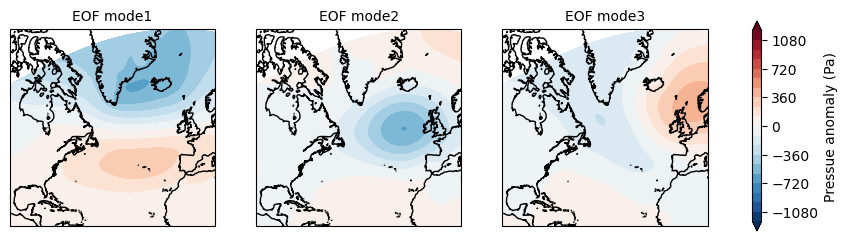

In [10]:
projection = ccrs.Mercator(central_longitude = (x_max + x_min)/2, min_latitude = y_min, max_latitude = y_max)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (9, 3), subplot_kw = {'projection': projection})

p1 = axes[0].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_SLP[0], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p2 = axes[1].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_SLP[1], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

p3 = axes[2].contourf(SLP_NA.geolon_t, SLP_NA.geolat_t, eof_SLP[2], levels = np.linspace(-1.2e3, 1.2e3, 21), 
                           cmap = 'RdBu_r', transform = ccrs.PlateCarree(), extend = 'both')

cax = plt.axes([0.95, 0.15, 0.01, 0.7])
cb = plt.colorbar(p1, cax = cax, orientation = 'vertical', ax = axes)
cb.ax.set_ylabel('Pressue anomaly (Pa)', fontsize = 10)

for i in range(3):
    axes[i].set_extent([x_min, x_max, y_min, y_max], crs=ccrs.PlateCarree())
    axes[i].coastlines(resolution = '50m')
    axes[i].set_title('EOF mode' + str(i+1), fontsize = 10)

In [12]:
print('Percentage of EOF explained by first ' + str(3) + ' modes:' + str(
    100 * np.round(solver_SLP.varianceFraction(neigs = 3).values, 4)))

Percentage of EOF explained by first 3 modes:[37.56     20.14     12.700001]


Text(15000.0, -4, '-0.32786596')

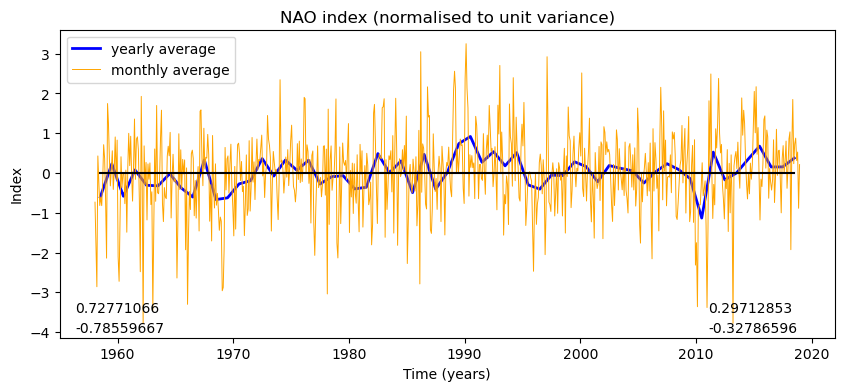

In [69]:
NAO_index = solver_SLP.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0)
plt.figure(figsize = (10, 4))
NAO_index.coarsen(time = 12).mean().plot(color = 'blue', lw = 2, label = 'yearly average')
NAO_index.plot(color = 'orange', lw = 0.7, label = 'monthly average')
plt.plot(NAO_index.coarsen(time = 12).mean().time, np.zeros(61), color = 'black')
plt.ylabel('Index')
plt.xlabel('Time (years)')
plt.title('NAO index (normalised to unit variance)')
plt.legend()

positive_cases_monthly_mean = xr.where(NAO_index >0, NAO_index, np.nan).mean('time').values
negative_cases_monthly_mean = xr.where(NAO_index <0, NAO_index, np.nan).mean('time').values

positive_cases_yearly_mean = xr.where(NAO_index.coarsen(time = 12).mean() >0, NAO_index.coarsen(time = 12).mean(), np.nan).mean('time').values
negative_cases_yearly_mean = xr.where(NAO_index.coarsen(time = 12).mean() <0, NAO_index.coarsen(time = 12).mean(), np.nan).mean('time').values

plt.text(-0.5e4, -3.5, positive_cases_monthly_mean)
plt.text(-0.5e4, -4, negative_cases_monthly_mean)

plt.text(1.5e4, -3.5, positive_cases_yearly_mean)
plt.text(1.5e4, -4, negative_cases_yearly_mean)

In the plot above, the two numbers on the left represent the mean positive and mean negative NAO phase calculated from monthly-mean NAO index. The two numbers on the right represent the mean positive and mean negative NAO phase calculated from yearly-mean NAO index. This is to give an indication of the spread of values, and to help make a choice regarding the amplitude of our anomalies.

In [17]:
NAO_index = solver_SLP.pcs(npcs = npcs, pcscaling = 1).sel(mode = 0)

j = 'uas'
var_forcing_input = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/' + j + '_raw.nc')[j]
b = var_forcing_input
b['time'] = NAO_index.time

correlation_uas = xr.corr(NAO_index, b, 'time')
regression_uas = ((NAO_index - NAO_index.mean('time'))*(b - b.mean('time'))/NAO_index.std('time')).mean('time')

j = 'vas'
var_forcing_input = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/' + j + '_raw.nc')[j]
b = var_forcing_input
b['time'] = NAO_index.time

correlation_vas = xr.corr(NAO_index, b, 'time')
regression_vas = ((NAO_index - NAO_index.mean('time'))*(b - b.mean('time'))/NAO_index.std('time')).mean('time')

In [22]:
uas = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/uas_raw.nc')['uas']
uas = uas.sel(time = slice('1990-05-01', '1991-04-30')).mean('time')

vas = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/vas_raw.nc')['vas']
vas = vas.sel(time = slice('1990-05-01', '1991-04-30')).mean('time')

Text(0.5, 1.0, 'v-wind speed for RYF year')

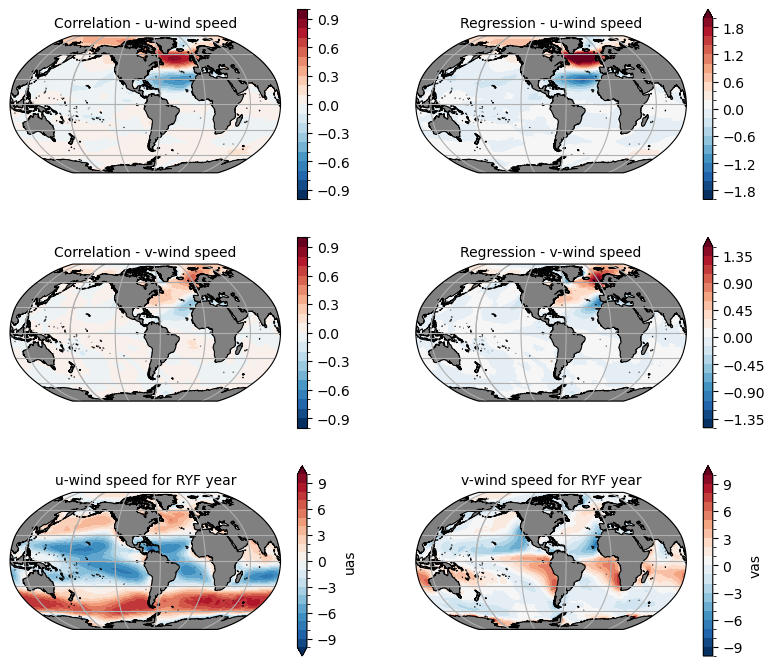

In [31]:
fig = plt.figure()
fig.set_figheight(7 * 1.2)
fig.set_figwidth(8 * 1.2)

var_series = ['uas', 'vas']
limits     = [2,     1.5]
label_series = ['u-wind speed', 'v-wind speed']

land_50m = cft.NaturalEarthFeature('physical', 'land', '50m', edgecolor='black', facecolor='gray', linewidth=0.5)

for i, j in enumerate(var_series):
    var_forcing_input = xr.open_dataset('/g/data/x77/db6174/Project_3/North-Atlantic-Oscillation-tests/NETCDF/Monthly_data/' + j + '_raw.nc')[j]

    b = var_forcing_input
    b['time'] = NAO_index.time

    correlation = xr.corr(NAO_index, b, 'time')
    regression = ((NAO_index - NAO_index.mean('time'))*(b - b.mean('time'))/NAO_index.std('time')).mean('time')


    ax1 = plt.subplot2grid(shape = (len(var_series)+1, 2), loc = (i, 0), rowspan = 1, colspan = 1, projection = ccrs.Robinson(central_longitude = -80))
    ax1.coastlines(resolution = '50m')
    ax1.add_feature(land_50m)
    gl = ax1.gridlines(draw_labels = False)

    ax2 = plt.subplot2grid(shape = (len(var_series)+1, 2), loc = (i, 1), rowspan = 1, colspan = 1, projection = ccrs.Robinson(central_longitude = -80))
    ax2.coastlines(resolution = '50m')
    ax2.add_feature(land_50m)
    gl = ax2.gridlines(draw_labels = False)

    p1 = correlation.plot.contourf(ax = ax1, x = 'lon', y = 'lat', cmap = 'RdBu_r', 
                                   transform = ccrs.PlateCarree(), levels = np.linspace(-1, 1, 21),
                                   add_colorbar = True, rasterized = True, zorder = -20)
    ax1.set_title('Correlation - ' + label_series[i], fontsize = 10)

    p2 = regression.plot.contourf(ax = ax2, x = 'lon', y = 'lat', cmap = 'RdBu_r', 
                                   transform = ccrs.PlateCarree(), levels = np.linspace(-limits[i], limits[i], 21),
                                   add_colorbar = True, rasterized = True, zorder = -20)
    ax2.set_title('Regression - ' + label_series[i], fontsize = 10)

ax1 = plt.subplot2grid(shape = (len(var_series)+1, 2), loc = (2, 0), rowspan = 1, colspan = 1, projection = ccrs.Robinson(central_longitude = -80))
ax1.coastlines(resolution = '50m')
ax1.add_feature(land_50m)
gl = ax1.gridlines(draw_labels = False)

p1 = uas.plot.contourf(ax = ax1, x = 'lon', y = 'lat', cmap = 'RdBu_r', 
                                   transform = ccrs.PlateCarree(), levels = np.linspace(-10, 10, 21),
                                   add_colorbar = True, rasterized = True, zorder = -20)
ax1.set_title('u-wind speed for RYF year', fontsize = 10)

ax2 = plt.subplot2grid(shape = (len(var_series)+1, 2), loc = (2, 1), rowspan = 1, colspan = 1, projection = ccrs.Robinson(central_longitude = -80))
ax2.coastlines(resolution = '50m')
ax2.add_feature(land_50m)
gl = ax2.gridlines(draw_labels = False)

p1 = vas.plot.contourf(ax = ax2, x = 'lon', y = 'lat', cmap = 'RdBu_r', 
                                   transform = ccrs.PlateCarree(), levels = np.linspace(-10, 10, 21),
                                   add_colorbar = True, rasterized = True, zorder = -20)
ax2.set_title('v-wind speed for RYF year', fontsize = 10)

Considering an anomaly of standard deviation = 1, the percentage change in zonal and meridional winds is between 20-40%, or 44-96% change in zonal and meridional wind stresses. Seems enough to perturb the gyre.